In [1]:
from collections import Counter
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

import numpy as np 
import pandas as pd

In [2]:
#Import the Dataset we are working with

In [3]:
data_url = 'https://raw.githubusercontent.com/georgetown-analytics/Formula1/main/data/processed/MasterData5.csv'
data_df = pd.read_csv(data_url, sep = ',', engine = 'python', encoding = 'latin-1')

**Modeling**

In [4]:
data_df.head()

,raceId,driverId,constructorId,grid,familyStatus,Completion Status,year,circuitId,country,alt,...,TAVG,TMAX,TMIN,oneHot_circuits_1,oneHot_circuits_2,oneHot_circuits_3,oneHot_circuits_4,oneHot_circuits_5,oneHot_circuits_6,trackType2
0,1,2,2,9,4,1,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1
1,1,3,3,5,4,1,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1
2,1,4,4,10,4,1,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1
3,1,6,3,11,1,0,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1
4,1,7,5,17,4,1,2009,1,Australia,10,...,72.0,78.0,66.0,0,1,0,0,0,0,1


In [5]:
data_df.shape

(9258, 26)

In [6]:
data_df.isna().sum()

raceId               0
driverId             0
constructorId        0
grid                 0
familyStatus         0
Completion Status    0
year                 0
circuitId            0
country              0
alt                  0
isHistoric           0
nationality          0
total_lap_time       0
average_lap_time     0
minimum_lap_time     0
PRCP                 0
TAVG                 0
TMAX                 0
TMIN                 0
oneHot_circuits_1    0
oneHot_circuits_2    0
oneHot_circuits_3    0
oneHot_circuits_4    0
oneHot_circuits_5    0
oneHot_circuits_6    0
trackType2           0
dtype: int64

In [7]:
#Position, fastest lap, rank, fastest lap speed all contain nulls. 
#This suggests that they would have high correlation to our target Completion Status. 
#These columns will be excluded from our feature selection. 

In [8]:
data_df = data_df.rename(columns={"Completion Status": "CompletionStatus"})
y = data_df.loc[:, 'CompletionStatus'] #categorical

In [9]:
X = data_df.loc[:, ['trackType2', #categorical
                        'alt', #numeric
                        'grid', #numeric
                        'average_lap_time', #numeric
                        'minimum_lap_time', #numeric
                        'year', #numeric
                        'PRCP', #numeric
                        'TAVG', #numeric
                        'isHistoric', #categorical
                        "oneHot_circuits_1",
                    "oneHot_circuits_2","oneHot_circuits_3","oneHot_circuits_4","oneHot_circuits_5",
                    "oneHot_circuits_6"
                    
                       ]]

/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


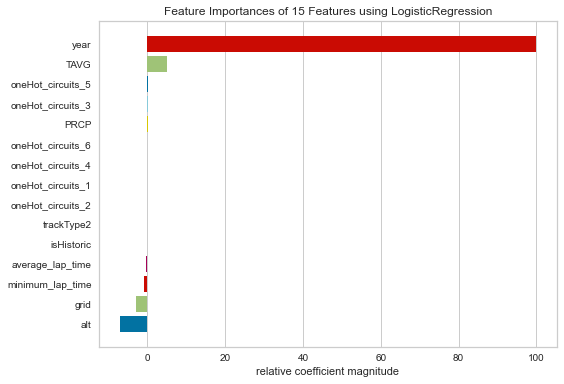

<AxesSubplot:title={'center':'Feature Importances of 15 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [10]:
from yellowbrick.features import FeatureImportances

model = LogisticRegression()
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show()

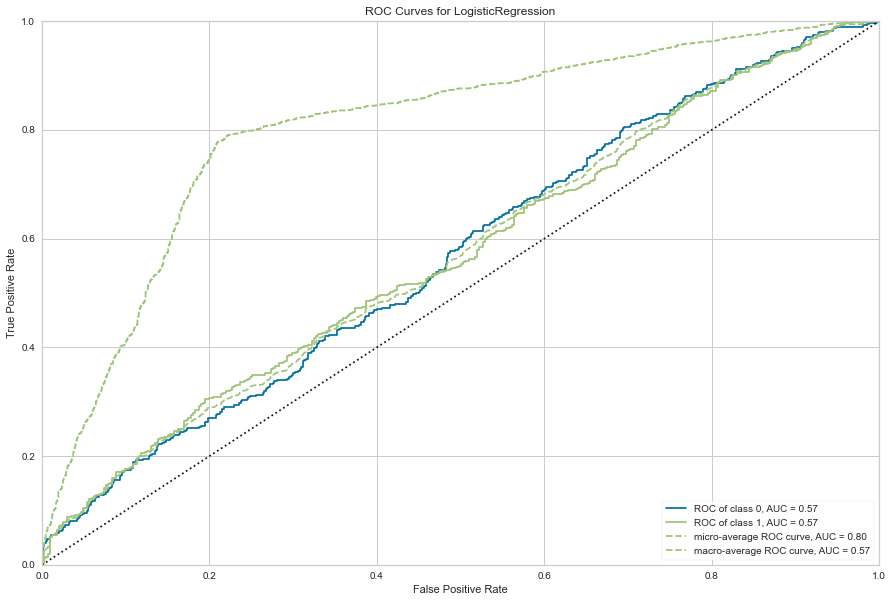

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from yellowbrick.classifier import ROCAUC


# Specify the classes of the target
classes = [0, 1]

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(LogisticRegression(
    multi_class="auto", solver="liblinear"
    ), classes=classes, size=(1080, 720)
)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [12]:
#Test our data on various estimators.

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state = 3)

def score_model(X_train, y_train, X_test, y_test, estimator, **kwargs):
   
    estimator.fit(X_train, y_train, **kwargs)  
    
    expected  = y_test
    predicted = estimator.predict(X_test)
    
    # Compute and return F1
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))
    

# Instantiate the classification models
models = [
    SVC(gamma='auto'), 
    LinearSVC(),  
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), 
    LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_train, y_train, X_test, y_test, model)

SVC: 0.8724505327245053


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC: 0.8724505327245053
KNeighborsClassifier: 0.8625929518267056
LogisticRegression: 0.8729820286323485
LogisticRegressionCV: 0.8735141725083816
BaggingClassifier: 0.8723475917817446
ExtraTreesClassifier: 0.8801858612678394
RandomForestClassifier: 0.8838901753225273


In [13]:
#These models are producing unsually high results. 
#It seems as if there is data leakage taking place. 

In [14]:
data_df.CompletionStatus.value_counts()

1    7108
0    2150
Name: CompletionStatus, dtype: int64

In [15]:
#Data leakage is potentially caused by a class imbalance. 

In [16]:
#Now to use SMOTE to address this issue. 

In [17]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 7108), (1, 7108)]


In [18]:
#Now to test various models on our resampled data

In [19]:
def score_model(X_resampled, y_resampled, X_test, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """
    # Instantiate the classification model and visualizer
    estimator.fit(X_resampled, y_resampled, **kwargs)  
    
    expected  = y_test
    predicted = estimator.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))
    

models = [
    SVC(gamma='auto'), 
    NuSVC(gamma='auto'), 
    LinearSVC(),  
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), 
    LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_resampled, y_resampled, X_test, y_test, model)

SVC: 1.0
NuSVC: 1.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC: 0.0
KNeighborsClassifier: 0.8662372110647973
LogisticRegression: 0.6745513866231646
LogisticRegressionCV: 0.6777462505066882
BaggingClassifier: 0.9926650366748166
ExtraTreesClassifier: 1.0
RandomForestClassifier: 1.0


In [20]:
#Logistic Regression, LogisticRegressionCV, LinearSVC, KNeighborsClassifier

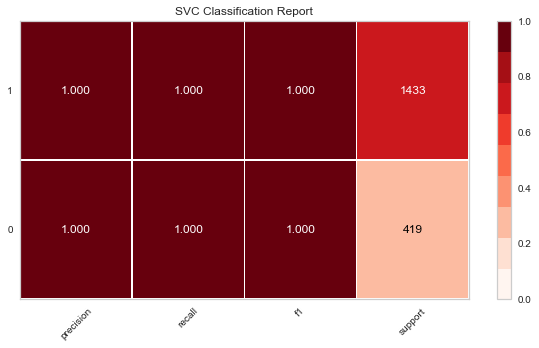

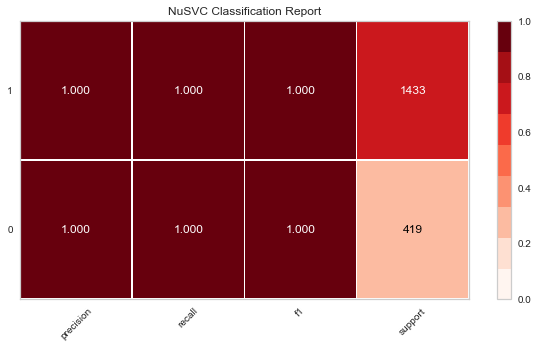

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


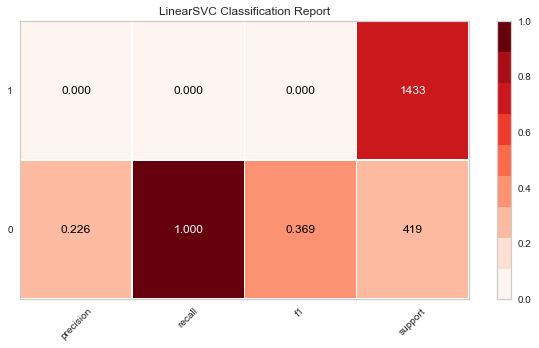

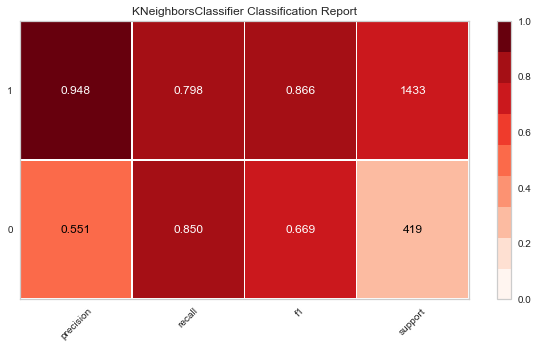

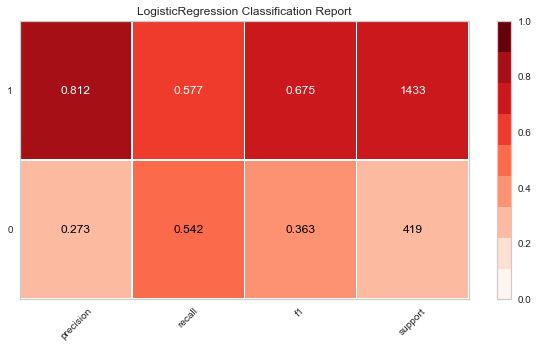

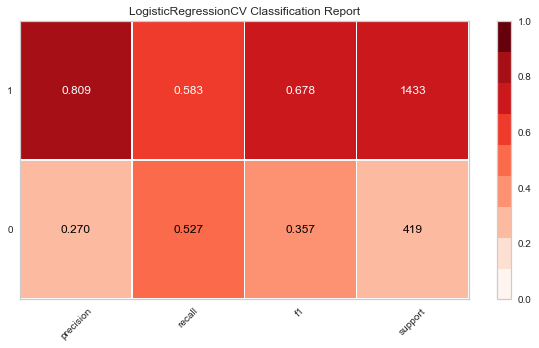

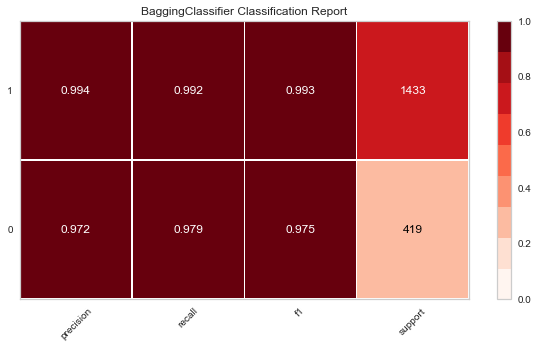

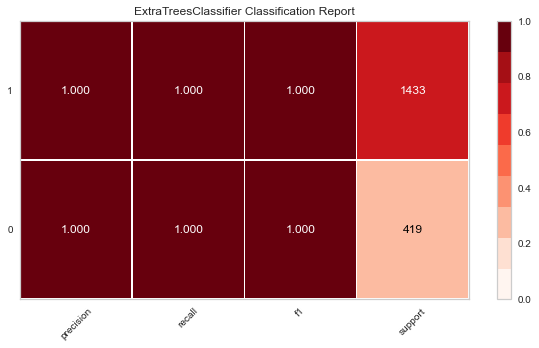

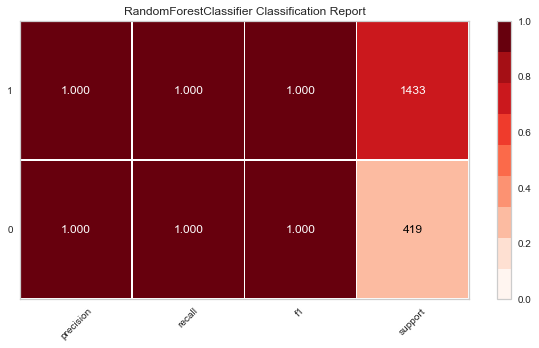

In [21]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        estimator, 
        classes=[0,1], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20, random_state = 3)
    X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
    visualizer.fit(X_resampled, y_resampled)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)

In [22]:
#LogisticRegression & LogisticRegressionCV seem to be our most viable models

In [23]:
# train a logistic regression model on the resammpled data 
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_resampled, y_resampled)

LogisticRegression(solver='liblinear')

In [24]:
y_pred_class = logreg.predict(X_test)

In [25]:
#Classification Accuracy

In [26]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7316414686825053


In [27]:
#Null Accuracy - accuracy that could be achieved by always predicting the most frequent class

In [28]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

1    1433
0     419
Name: CompletionStatus, dtype: int64

In [29]:
# calculate the percentage of ones
y_test.mean()

0.7737580993520519

In [30]:
# calculate the percentage of zeros
1 - y_test.mean()

0.22624190064794814

In [31]:
# calculate null accuracy
max(y_test.mean(), 1 - y_test.mean())

0.7737580993520519

In [32]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[  37  382]
 [ 115 1318]]


In [33]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [34]:
#Classification Accuracy: Overall, how often is the classifier correct?

In [35]:
print((TP + TN) / (TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.7316414686825053
0.7316414686825053


In [36]:
#Classification Error: Overall, how often is the classifier incorrect?

In [37]:
print((FP + FN) / (TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.2683585313174946
0.26835853131749465


In [38]:
#Sensitivity: When the actual value is positive, how often is the prediction correct?

In [39]:
print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.9197487787857641
0.9197487787857641


In [40]:
#Specificity: When the actual value is negative, how often is the prediction correct?
#In this case, when we predict crash, how often are we correct?
#In this case we want to optimize specificity

In [41]:
#Specificity:

print(TN / (TN + FP))

0.0883054892601432


In [42]:
#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

In [43]:
print(FP / (TN + FP))

0.9116945107398569


In [44]:
#Precision: When a positive value is predicted, how often is the prediction correct?

In [45]:
print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.7752941176470588
0.7752941176470588


In [46]:
#Adjusting the classification threshold

In [47]:
logreg.predict_proba(X_test)

array([[0.2656263 , 0.7343737 ],
       [0.50459922, 0.49540078],
       [0.27220582, 0.72779418],
       ...,
       [0.34204148, 0.65795852],
       [0.42799521, 0.57200479],
       [0.26134652, 0.73865348]])

In [48]:
logreg.predict_proba(X_test)[0:10, 0]

array([0.2656263 , 0.50459922, 0.27220582, 0.29458557, 0.49234535,
       0.35537911, 0.18118916, 0.75742041, 0.32000822, 0.33716918])

In [49]:
y_pred_prob = logreg.predict_proba(X_test)[:, 0]

In [50]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

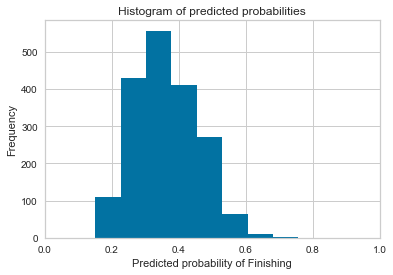

In [51]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Finishing')
plt.ylabel('Frequency')

In [52]:
#Increase the threshold for predicting crashes in order to increase the specificity of the classifier

In [53]:
# predict crash if the predicted probability is less than 0.3
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], threshold=0.3)[0]

In [54]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([0.2656263 , 0.50459922, 0.27220582, 0.29458557, 0.49234535,
       0.35537911, 0.18118916, 0.75742041, 0.32000822, 0.33716918])

In [55]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([0., 1., 0., 0., 1., 1., 0., 1., 1., 1.])

In [56]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[  37  382]
 [ 115 1318]]


In [57]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[ 82 337]
 [440 993]]


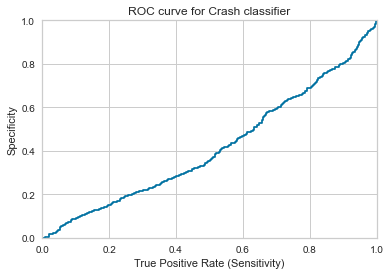

In [58]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Crash classifier')
#'True Positive Rate (Sensitivity)'
plt.xlabel('True Positive Rate (Sensitivity)')
plt.ylabel('Specificity')
plt.grid(True)

In [59]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])


In [60]:
evaluate_threshold(0.5)

Sensitivity: 0.08025122121423586
Specificity: 0.9116945107398569


In [61]:
evaluate_threshold(0.3)

Sensitivity: 0.6922540125610607
Specificity: 0.19570405727923623


In [62]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.414738177996659


In [63]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.5650058060066808

In [64]:
#Parameter tuning using GridSearchCV

In [71]:
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6989057497862641
Test score: 0.6832531972655611


In [76]:
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LinearSVC()]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6985369574965311
Test score: 0.6828345271972001


In [68]:
#Logisitc Regression, LogisticRegressionCV, LinearSVC, KNeighborsClassifier

In [72]:
grid_search.best_params_

{'classifier__C': 10}

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__penalty' : ['l1', 'l2'],
              "classifier__C":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'classifier__solver' : ['liblinear']}

             
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6989495951189406
Test score: 0.683240113825925
